In [9]:
# ======================================
# ✅ 통합: 전처리 + 학년별 sample_weight + 변수선택 + CV/Hold-out 평가
# ======================================

import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedKFold, train_test_split, cross_validate
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.feature_selection import RFECV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score
import warnings

warnings.filterwarnings("ignore")
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

# -------------------------
# 0️⃣ 데이터 로드
# -------------------------
df = pd.read_csv('univ355.csv')

# -------------------------
# 1️⃣ 결측치 컬럼 제거
# -------------------------
drop_missing_cols = [
    'why_not_rechoice', 'future_job_desc', 'income_class', 'income_contest',
    'income_perf', 'income_broadcast', 'income_studio', 'income_creator',
    'income_choreo', 'info_dept', 'info_career_center', 'info_online',
    'info_family', 'info_friends', 'info_academy', 'info_self',
    'help_financial', 'help_resume', 'help_career', 'help_social',
    'help_no', 'non_stay_reason', 'total_univ'
]
df = df.drop(columns=drop_missing_cols, errors='ignore')

# -------------------------
# 2️⃣ current_area 관련 변수 제거
# -------------------------
current_area_cols = [col for col in df.columns if col.startswith('current_area')]
df = df.drop(columns=current_area_cols, errors='ignore')

# -------------------------
# 3️⃣ 오타 수정
# -------------------------
if 'birth_area' in df.columns:
    df['birth_area'] = df['birth_area'].replace({'g': 'gangwon'})

# -------------------------
# 4️⃣ 범주형 변수 매핑 및 원-핫 인코딩
# -------------------------
midpoint_map = {'less2':1, '2to4':2, '4to7':3, '7to10':4, 'over10':5}
if 'dance_years' in df.columns:
    df['dance_years'] = df['dance_years'].map(midpoint_map)

columns_to_encode = [
    'univ_factor', 'major_factor', 'job_region', 'weight_control',
    'birth_area', 'housing_type', 'enter_type',
    'major_detail', 'univ_name', 'univ_area'
]
df = pd.get_dummies(df, columns=columns_to_encode, drop_first=False, dtype=float)

# -------------------------
# 5️⃣ 분석 제외 변수 제거
# -------------------------
remove_vars = ["prof_hi", "int_major", "enter_year"]
df = df.drop(columns=remove_vars, errors='ignore')

# -------------------------
# 6️⃣ 상관계수 높은 변수 사전 삭제
# -------------------------
high_corr_remove = ['lecture_qual', 'peer_personal', 'enjoy_major', 'prof_chat','peer_study']
df = df.drop(columns=high_corr_remove, errors='ignore')

# -------------------------
# 7️⃣ sat 변수 생성 및 이진 분류
# -------------------------
sat_cols = ['univ_proud', 'univ_belong', 'major_proud', 'major_belong']
df['sat'] = df[sat_cols].mean(axis=1)
sat_median = df['sat'].median()
df['sat_group'] = (df['sat'] >= sat_median).astype(int)

# -------------------------
# 8️⃣ 학년별 sample_weight 계산
# - 학년별 희소도를 반영: count가 적은 학년일수록 weight 증가
# -------------------------
grade_counts = df['grade'].value_counts().to_dict()
grade_weights = {grade: 1/count for grade, count in grade_counts.items()}
df['sample_weight'] = df['grade'].map(grade_weights)

# -------------------------
# 9️⃣ 학습/테스트 분할
# -------------------------
target_col = 'sat_group'
X = df.drop(columns=[target_col, 'sat', 'sample_weight'], errors='ignore')
y = df[target_col]
sample_weights = df['sample_weight']

X_train, X_test, y_train, y_test, sw_train, sw_test = train_test_split(
    X, y, sample_weights, test_size=0.2, stratify=y, random_state=RANDOM_STATE
)

# -------------------------
# 10️⃣ CV 설정
# -------------------------
inner_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
scoring = {"accuracy": "accuracy", "f1": "f1", "roc_auc": "roc_auc"}

# -------------------------
# 11️⃣ RFECV 파이프라인 함수
# -------------------------
def make_rfecv_pipeline(base_estimator, final_estimator=None):
    if final_estimator is None:
        final_estimator = base_estimator
    rfecv = RFECV(
        estimator=base_estimator,
        step=1,
        cv=inner_cv,
        scoring='f1',
        min_features_to_select=max(1, int(0.05 * X_train.shape[1])),
        n_jobs=1,
        verbose=0
    )
    if isinstance(base_estimator, LogisticRegression):
        return Pipeline([("scaler", StandardScaler()),
                         ("feature_selection", rfecv),
                         ("clf", final_estimator)])
    else:
        return Pipeline([("feature_selection", rfecv),
                         ("clf", final_estimator)])

# -------------------------
# 12️⃣ 모델 정의
# -------------------------
models = {
    "ElasticNet": Pipeline([
        ("scaler", StandardScaler()),
        ("clf", LogisticRegressionCV(
            Cs=10, cv=inner_cv, penalty="elasticnet", solver="saga",
            l1_ratios=[.1,.3,.5,.7,.9], scoring="f1",
            max_iter=5000, random_state=RANDOM_STATE, n_jobs=-1
        ))
    ]),
    "RFECV_LR": make_rfecv_pipeline(LogisticRegression(max_iter=1000, solver='liblinear', random_state=RANDOM_STATE),
                                    LogisticRegression(max_iter=1000, solver='liblinear', random_state=RANDOM_STATE)),
    "RFECV_DT": make_rfecv_pipeline(DecisionTreeClassifier(random_state=RANDOM_STATE),
                                    DecisionTreeClassifier(random_state=RANDOM_STATE)),
    "RFECV_RF": make_rfecv_pipeline(RandomForestClassifier(n_estimators=200, random_state=RANDOM_STATE, n_jobs=-1),
                                    RandomForestClassifier(n_estimators=200, random_state=RANDOM_STATE, n_jobs=-1)),
    "RFECV_XGB": make_rfecv_pipeline(XGBClassifier(n_estimators=200, random_state=RANDOM_STATE,
                                                   use_label_encoder=False, eval_metric='logloss', n_jobs=-1),
                                     XGBClassifier(n_estimators=200, random_state=RANDOM_STATE,
                                                   use_label_encoder=False, eval_metric='logloss', n_jobs=-1))
}

# -------------------------
# 13️⃣ RFECV 변수선택 + CV/Hold-out 평가 (sample_weight 적용)
# -------------------------
results = []
for name, pipe in models.items():
    print(f"\n===== 평가 중: {name} =====")
    
    # cross_validate용 fit_params (sample_weight 전달)
    fit_params = {}
    if "clf" in pipe.named_steps and hasattr(pipe.named_steps["clf"], "fit"):
        fit_params = {"clf__sample_weight": sw_train}

    # CV 평가
    cv_res = cross_validate(pipe, X_train, y_train, cv=outer_cv, scoring=scoring,
                            n_jobs=-1, error_score=np.nan, fit_params=fit_params)
    
    cv_mean = {m: np.nanmean(cv_res[f"test_{m}"]) for m in scoring.keys()}
    cv_std = {m: np.nanstd(cv_res[f"test_{m}"]) for m in scoring.keys()}

    # Hold-out 평가
    fitted_pipe = pipe.fit(X_train, y_train, **fit_params)
    y_pred = fitted_pipe.predict(X_test)
    try:
        y_score = fitted_pipe.predict_proba(X_test)[:,1]
    except:
        try: y_score = fitted_pipe.decision_function(X_test)
        except: y_score = None

    holdout_metrics = {
        "accuracy": accuracy_score(y_test, y_pred),
        "f1": f1_score(y_test, y_pred),
        "precision": precision_score(y_test, y_pred, zero_division=0),
        "recall": recall_score(y_test, y_pred),
        "roc_auc": roc_auc_score(y_test, y_score) if y_score is not None else np.nan
    }

    # 최종 선택 변수
    final_selected = []
    if "feature_selection" in fitted_pipe.named_steps:
        try: final_selected = list(X_train.columns[fitted_pipe.named_steps['feature_selection'].support_])
        except: final_selected = []
    elif name == "ElasticNet":
        try: final_selected = list(X_train.columns[fitted_pipe.named_steps['clf'].coef_.ravel()!=0])
        except: final_selected = []

    results.append({
        "model": name,
        "cv_mean": cv_mean,
        "cv_std": cv_std,
        "holdout": holdout_metrics,
        "final_selected": sorted(final_selected)
    })

# -------------------------
# 14️⃣ 결과 정리
# -------------------------
summary_rows = []
for r in results:
    summary_rows.append({
        "model": r["model"],
        "CV_f1_mean": r["cv_mean"]["f1"],
        "CV_acc_mean": r["cv_mean"]["accuracy"],
        "CV_roc_mean": r["cv_mean"]["roc_auc"],
        "Holdout_f1": r["holdout"]["f1"],
        "Holdout_acc": r["holdout"]["accuracy"],
        "Holdout_roc": r["holdout"]["roc_auc"],
        "final_selected_vars": ", ".join(r["final_selected"])
    })

summary_df = pd.DataFrame(summary_rows).sort_values(by="CV_f1_mean", ascending=False)
print("\n\n=== 요약 표 ===")
display(summary_df)



===== 평가 중: ElasticNet =====

===== 평가 중: RFECV_LR =====

===== 평가 중: RFECV_DT =====

===== 평가 중: RFECV_RF =====

===== 평가 중: RFECV_XGB =====


=== 요약 표 ===


,model,CV_f1_mean,CV_acc_mean,CV_roc_mean,Holdout_f1,Holdout_acc,Holdout_roc,final_selected_vars
2,RFECV_DT,0.991546,0.989474,0.988052,0.964706,0.957746,0.958887,"major_belong, univ_area_chungcheong, univ_area..."
3,RFECV_RF,0.991546,0.989411,0.999481,0.976744,0.971831,0.993355,"course_variety, id, major_belong, major_proud,..."
1,RFECV_LR,0.970479,0.964850,0.995333,0.941176,0.929577,0.994186,"exp_video, major_belong, major_proud, peer_eve..."
0,ElasticNet,0.969455,0.961278,0.997143,0.976744,0.971831,0.990864,"birth_area_chungcheong, change_major, drink_fr..."
4,RFECV_XGB,0.754360,0.605639,0.500000,0.754386,0.605634,0.500000,"abroad_practice, birth_area_chungcheong, job_r..."


In [10]:
# ======================================
# ✅ 전체 통합: RFECV/ElasticNet → stable_vars 추출 → 안정적 변수 기반 모델링
# ======================================

import numpy as np
import pandas as pd
from itertools import combinations
from sklearn.model_selection import StratifiedKFold, train_test_split, cross_validate
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.feature_selection import RFECV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import (
    accuracy_score, f1_score, precision_score, recall_score, roc_auc_score,
    balanced_accuracy_score, matthews_corrcoef, precision_recall_curve
)
import warnings
warnings.filterwarnings("ignore")

# ==========================
# 0️⃣ 설정
# ==========================
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

# df가 이미 전처리 완료 상태라는 가정
try:
    df
except NameError:
    raise RuntimeError("데이터프레임 df가 존재하지 않습니다. 먼저 전처리 셀을 실행하세요.")

target_col = 'sat_group'
drop_cols = ['id','univ_proud','univ_belong','major_proud','major_belong','sat','sat_group']
X = df.drop(columns=[c for c in drop_cols if c in df.columns], errors='ignore')
y = df[target_col].copy()

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=RANDOM_STATE
)

inner_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

scoring = {"accuracy": "accuracy", "f1": "f1", "roc_auc": "roc_auc"}

# ==========================
# 1️⃣ RFECV/ElasticNet 파이프라인 정의
# ==========================
enet_pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", LogisticRegressionCV(
        Cs=10, cv=inner_cv, penalty="elasticnet", solver="saga",
        l1_ratios=[.1, .3, .5, .7, .9], scoring="f1",
        max_iter=5000, random_state=RANDOM_STATE, n_jobs=-1
    ))
])

def make_rfecv_pipeline(base_estimator, final_estimator=None):
    if final_estimator is None:
        final_estimator = base_estimator
    rfecv = RFECV(
        estimator=base_estimator, step=1, cv=inner_cv, scoring='f1',
        min_features_to_select=max(1, int(0.05 * X_train.shape[1])),
        n_jobs=1, verbose=0
    )
    return Pipeline([("feature_selection", rfecv), ("clf", final_estimator)])

models = {
    "ElasticNet": enet_pipeline,
    "RFECV_LR": Pipeline([
        ("scaler", StandardScaler()),
        ("feature_selection", RFECV(
            estimator=LogisticRegression(max_iter=1000, solver='liblinear', random_state=RANDOM_STATE),
            step=1, cv=inner_cv, scoring='f1',
            min_features_to_select=max(1, int(0.05 * X_train.shape[1])),
            n_jobs=1
        )),
        ("clf", LogisticRegression(max_iter=1000, solver='liblinear', random_state=RANDOM_STATE))
    ]),
    "RFECV_DT": make_rfecv_pipeline(
        DecisionTreeClassifier(random_state=RANDOM_STATE),
        DecisionTreeClassifier(random_state=RANDOM_STATE)
    ),
    "RFECV_RF": make_rfecv_pipeline(
        RandomForestClassifier(n_estimators=200, random_state=RANDOM_STATE, n_jobs=-1),
        RandomForestClassifier(n_estimators=200, random_state=RANDOM_STATE, n_jobs=-1)
    ),
    "RFECV_XGB": make_rfecv_pipeline(
        XGBClassifier(n_estimators=200, random_state=RANDOM_STATE,
                      use_label_encoder=False, eval_metric='logloss', n_jobs=-1),
        XGBClassifier(n_estimators=200, random_state=RANDOM_STATE,
                      use_label_encoder=False, eval_metric='logloss', n_jobs=-1)
    )
}

# ==========================
# 2️⃣ 폴드별 선택 변수 추출 (stable_vars)
# ==========================
print(">>> 폴드별 선택 변수 계산 중 ...")
selected_per_model = {}

for name, pipe in models.items():
    fold_sets = []
    for tr_idx, val_idx in outer_cv.split(X_train, y_train):
        X_tr_fold = X_train.iloc[tr_idx]
        y_tr_fold = y_train.iloc[tr_idx]

        if name == "ElasticNet":
            enet_fold = LogisticRegressionCV(
                Cs=10, cv=inner_cv, penalty="elasticnet", solver="saga",
                l1_ratios=[.1, .3, .5, .7, .9],
                scoring="f1", max_iter=5000, random_state=RANDOM_STATE, n_jobs=-1
            )
            enet_fold.fit(X_tr_fold, y_tr_fold)
            sel = set(X_tr_fold.columns[enet_fold.coef_.ravel() != 0])
        else:
            if name == "RFECV_LR":
                base = LogisticRegression(max_iter=1000, solver='liblinear', random_state=RANDOM_STATE)
            elif name == "RFECV_DT":
                base = DecisionTreeClassifier(random_state=RANDOM_STATE)
            elif name == "RFECV_RF":
                base = RandomForestClassifier(n_estimators=200, random_state=RANDOM_STATE, n_jobs=-1)
            elif name == "RFECV_XGB":
                base = XGBClassifier(n_estimators=200, random_state=RANDOM_STATE,
                                     eval_metric='logloss', n_jobs=-1)
            rfecv_fold = RFECV(
                estimator=base, step=1, cv=inner_cv, scoring='f1',
                min_features_to_select=max(1, int(0.05 * X_train.shape[1])), n_jobs=1
            )
            rfecv_fold.fit(X_tr_fold, y_tr_fold)
            sel = set(X_tr_fold.columns[rfecv_fold.support_])
        fold_sets.append(sel)
    selected_per_model[name] = fold_sets
    intersec = set.intersection(*fold_sets) if fold_sets else set()
    print(f" - {name}: fold별 선택 수 = {[len(s) for s in fold_sets]}, 교집합(안정적) 수 = {len(intersec)}")

# Jaccard 안정성 지수
def mean_pairwise_jaccard(list_of_sets):
    if len(list_of_sets) < 2:
        return np.nan
    from itertools import combinations
    scores = [len(list_of_sets[i] & list_of_sets[j]) / len(list_of_sets[i] | list_of_sets[j])
              if len(list_of_sets[i] | list_of_sets[j]) > 0 else 1.0
              for i,j in combinations(range(len(list_of_sets)),2)]
    return np.mean(scores)

# ==========================
# 3️⃣ 파이프라인 전체 CV + Hold-out 평가
# ==========================
results = []
for name, pipe in models.items():
    print(f"\n===== 평가 중: {name} =====")
    # CV
    cv_res = cross_validate(pipe, X_train, y_train, cv=outer_cv, scoring=scoring, n_jobs=-1, error_score=np.nan)
    cv_mean = {k: np.nanmean(cv_res[f"test_{k}"]) for k in scoring}
    cv_std = {k: np.nanstd(cv_res[f"test_{k}"]) for k in scoring}

    # Hold-out
    fitted_pipe = pipe.fit(X_train, y_train)
    y_pred = fitted_pipe.predict(X_test)
    try:
        y_score = fitted_pipe.predict_proba(X_test)[:,1]
    except:
        y_score = fitted_pipe.decision_function(X_test) if hasattr(fitted_pipe, "decision_function") else None

    holdout_metrics = {
        "accuracy": accuracy_score(y_test, y_pred),
        "f1": f1_score(y_test, y_pred),
        "precision": precision_score(y_test, y_pred, zero_division=0),
        "recall": recall_score(y_test, y_pred),
        "roc_auc": roc_auc_score(y_test, y_score) if y_score is not None else np.nan
    }

    fold_sets = selected_per_model[name]
    jacc = mean_pairwise_jaccard(fold_sets)
    stable_vars = set.intersection(*fold_sets) if fold_sets else set()

    # 최종 선택 변수
    final_selected = []
    if "feature_selection" in fitted_pipe.named_steps:
        try:
            mask = fitted_pipe.named_steps['feature_selection'].support_
            final_selected = list(X_train.columns[mask])
        except: final_selected = []
    elif name == "ElasticNet":
        final_selected = list(X_train.columns[fitted_pipe.named_steps['clf'].coef_.ravel() != 0])

    results.append({
        "model": name,
        "cv_mean": cv_mean,
        "cv_std": cv_std,
        "holdout": holdout_metrics,
        "jaccard": jacc,
        "stable_vars": sorted(stable_vars),
        "final_selected": sorted(final_selected)
    })

# ==========================
# 4️⃣ 안정적 변수 기반 최종 모델링
# ==========================
final_models = {
    "LogReg": Pipeline([
        ("scaler", StandardScaler()),
        ("clf", LogisticRegression(max_iter=1000, solver='liblinear', random_state=RANDOM_STATE))
    ]),
    "DT": DecisionTreeClassifier(random_state=RANDOM_STATE),
    "RF": RandomForestClassifier(n_estimators=200, random_state=RANDOM_STATE, n_jobs=-1),
    "XGB": XGBClassifier(n_estimators=200, random_state=RANDOM_STATE,
                         use_label_encoder=False, eval_metric='logloss', n_jobs=-1)
}


stable_vars_dict = {r["model"]: r["stable_vars"] for r in results}
results_final = []

for source, stable_vars in stable_vars_dict.items():
    if not stable_vars:
        results_final.append({"source": source, "model": None, "n_features":0})
        continue
    for m_name, clf in final_models.items():
        pipe = Pipeline([("scaler", StandardScaler()), ("clf", clf)]) if m_name=="LogReg" else Pipeline([("clf", clf)])
        # CV
        cv_res = cross_validate(pipe, X_train[stable_vars], y_train, cv=outer_cv, scoring=scoring, n_jobs=-1)
        cv_mean = {k: np.mean(cv_res[f"test_{k}"]) for k in scoring}
        cv_std = {k: np.std(cv_res[f"test_{k}"]) for k in scoring}
        # Hold-out
        pipe.fit(X_train[stable_vars], y_train)
        y_pred = pipe.predict(X_test[stable_vars])
        try: y_score = pipe.predict_proba(X_test[stable_vars])[:,1]
        except: y_score = pipe.decision_function(X_test[stable_vars])
        holdout = {
            "accuracy": accuracy_score(y_test, y_pred),
            "balanced_acc": balanced_accuracy_score(y_test, y_pred),
            "f1": f1_score(y_test, y_pred),
            "precision": precision_score(y_test, y_pred, zero_division=0),
            "recall": recall_score(y_test, y_pred),
            "roc_auc": roc_auc_score(y_test, y_score),
            "mcc": matthews_corrcoef(y_test, y_pred)
        }
        results_final.append({
            "source": source,
            "model": m_name,
            "n_features": len(stable_vars),
            **{f"CV_{k}_mean": v for k,v in cv_mean.items()},
            **{f"CV_{k}_std": cv_std[k] for k in scoring},
            **{f"Test_{k}": v for k,v in holdout.items()}
        })

results_final_df = pd.DataFrame(results_final)
print("\n\n=== 안정적 변수 기반 최종 성능표 ===")
display(results_final_df.sort_values(by="CV_f1_mean", ascending=False))

# ==========================
# 5️⃣ 상세 안정적 변수 / 최종 선택 변수 출력
# ==========================
for r in results:
    print(f"\n--- {r['model']} ---")
    print(f"폴드 교집합(안정적) 변수 수: {len(r['stable_vars'])}")
    if r['stable_vars']: print("안정적 변수 (알파벳순):", ", ".join(r['stable_vars']))
    else: print("안정적 변수: 없음")
    print(f"파이프라인 기반 최종 선택 변수 수: {len(r['final_selected'])}")
    if r['final_selected']: print("최종 선택 변수 (알파벳순):", ", ".join(r['final_selected']))


>>> 폴드별 선택 변수 계산 중 ...
 - ElasticNet: fold별 선택 수 = [30, 30, 62, 63, 24], 교집합(안정적) 수 = 17
 - RFECV_LR: fold별 선택 수 = [16, 58, 55, 53, 59], 교집합(안정적) 수 = 8
 - RFECV_DT: fold별 선택 수 = [85, 168, 133, 153, 168], 교집합(안정적) 수 = 55
 - RFECV_RF: fold별 선택 수 = [74, 72, 71, 124, 148], 교집합(안정적) 수 = 66
 - RFECV_XGB: fold별 선택 수 = [77, 16, 75, 61, 32], 교집합(안정적) 수 = 10

===== 평가 중: ElasticNet =====

===== 평가 중: RFECV_LR =====

===== 평가 중: RFECV_DT =====

===== 평가 중: RFECV_RF =====

===== 평가 중: RFECV_XGB =====


=== 안정적 변수 기반 최종 성능표 ===


,source,model,n_features,CV_accuracy_mean,CV_f1_mean,CV_roc_auc_mean,CV_accuracy_std,CV_f1_std,CV_roc_auc_std,Test_accuracy,Test_balanced_acc,Test_f1,Test_precision,Test_recall,Test_roc_auc,Test_mcc
14,RFECV_RF,RF,66,0.827381,0.862200,0.892939,0.043896,0.037218,0.040095,0.859155,0.846346,0.886364,0.866667,0.906977,0.884136,0.702684
16,RFECV_XGB,LogReg,10,0.823997,0.859121,0.905440,0.051865,0.039870,0.046934,0.774648,0.770349,0.809524,0.829268,0.790698,0.860050,0.534952
2,ElasticNet,RF,17,0.816855,0.851804,0.901064,0.049290,0.041428,0.043440,0.788732,0.781977,0.823529,0.833333,0.813953,0.893688,0.560703
18,RFECV_XGB,RF,10,0.820301,0.851421,0.882684,0.065459,0.055146,0.056916,0.830986,0.823090,0.860465,0.860465,0.860465,0.897425,0.646179
3,ElasticNet,XGB,17,0.820489,0.850968,0.889023,0.041838,0.038636,0.028696,0.746479,0.747093,0.780488,0.820513,0.744186,0.877907,0.485396
0,ElasticNet,LogReg,17,0.820551,0.850605,0.902116,0.049738,0.047106,0.042281,0.774648,0.776578,0.804878,0.846154,0.767442,0.874585,0.543317
15,RFECV_RF,XGB,66,0.816855,0.850601,0.882355,0.039594,0.032404,0.047697,0.845070,0.834718,0.873563,0.863636,0.883721,0.885382,0.673928
19,RFECV_XGB,XGB,10,0.802757,0.836898,0.874127,0.057215,0.051440,0.038137,0.802817,0.799834,0.833333,0.853659,0.813953,0.898256,0.593296
4,RFECV_LR,LogReg,8,0.792293,0.831643,0.880595,0.038848,0.031964,0.020964,0.704225,0.705980,0.740741,0.789474,0.697674,0.796927,0.403664
11,RFECV_DT,XGB,55,0.760777,0.806825,0.825969,0.059721,0.049077,0.033240,0.788732,0.775748,0.827586,0.818182,0.837209,0.833056,0.555196



--- ElasticNet ---
폴드 교집합(안정적) 변수 수: 17
안정적 변수 (알파벳순): course_variety, know_reason, move_univ, peer_advice, peer_event, peer_external, prof_access, prof_event, prof_passion, student_interact, students_diligent, study_hard, support_fac, theory_cls, time_eff, try_hard, work_fee
파이프라인 기반 최종 선택 변수 수: 91
최종 선택 변수 (알파벳순): abroad_practice, admin_serv, birth_area_chungcheong, birth_area_gangwon, birth_area_seoul, burnout, career_course, change_career, change_major, course_variety, drink_freq, drop_out, edu_doubt, enter_type_early, exercise_reg, exp_concours, exp_video, field_practice, fit_major, gender, go_grad, has_income, housing_edu, housing_green, housing_infra, housing_neighbor, housing_type_independent, housing_type_parents, job_prep, job_region_abroad, job_region_honam, job_region_yeongnam, job_test, know_reason, learn_fun, major_detail_jazzdance, major_detail_sportsdance, major_detail_streetdance, major_factor_on_interest, major_factor_total, major_rank, move_univ, peer_advice, peer_c

In [11]:
# ======================================
# ✅ 3️⃣ 복합지표 계산 및 정렬
# ======================================

combined_results_df = results_final_df.copy()

# 1. 성능 평균 (F1, ROC_AUC, Balanced Accuracy)
combined_results_df["perf_mean"] = combined_results_df[
    ["Test_f1", "Test_roc_auc", "Test_balanced_acc"]
].mean(axis=1)

# 2. 과적합 정도 (CV vs Test 차이 평균)
combined_results_df["overfit_gap"] = (
    abs(combined_results_df["CV_f1_mean"] - combined_results_df["Test_f1"]) +
    abs(combined_results_df["CV_roc_auc_mean"] - combined_results_df["Test_roc_auc"]) +
    abs(combined_results_df["CV_accuracy_mean"] - combined_results_df["Test_balanced_acc"])
) / 3

# 3. 변수 복잡도 penalty (전체 변수 수 대비)
total_features = X.shape[1]
combined_results_df["var_penalty"] = combined_results_df["n_features"] / total_features

# 4. 최종 복합지표 계산
combined_results_df["composite_score"] = (
    combined_results_df["perf_mean"]
    - 0.5 * combined_results_df["overfit_gap"]
    - 0.2 * combined_results_df["var_penalty"]
)

# 5. 정렬 후 결과 확인
combined_results_df = combined_results_df.sort_values(by="composite_score", ascending=False)

print("\n=== 복합지표 기준 상위 10개 모델 ===")
display(combined_results_df.head(10))



=== 복합지표 기준 상위 10개 모델 ===


,source,model,n_features,CV_accuracy_mean,CV_f1_mean,CV_roc_auc_mean,CV_accuracy_std,CV_f1_std,CV_roc_auc_std,Test_accuracy,Test_balanced_acc,Test_f1,Test_precision,Test_recall,Test_roc_auc,Test_mcc,perf_mean,overfit_gap,var_penalty,composite_score
18,RFECV_XGB,RF,10,0.820301,0.851421,0.882684,0.065459,0.055146,0.056916,0.830986,0.823090,0.860465,0.860465,0.860465,0.897425,0.646179,0.860327,0.008858,0.058140,0.844270
19,RFECV_XGB,XGB,10,0.802757,0.836898,0.874127,0.057215,0.051440,0.038137,0.802817,0.799834,0.833333,0.853659,0.813953,0.898256,0.593296,0.843808,0.010205,0.058140,0.827077
2,ElasticNet,RF,17,0.816855,0.851804,0.901064,0.049290,0.041428,0.043440,0.788732,0.781977,0.823529,0.833333,0.813953,0.893688,0.560703,0.833065,0.023510,0.098837,0.801542
14,RFECV_RF,RF,66,0.827381,0.862200,0.892939,0.043896,0.037218,0.040095,0.859155,0.846346,0.886364,0.866667,0.906977,0.884136,0.702684,0.872282,0.017310,0.383721,0.786883
15,RFECV_RF,XGB,66,0.816855,0.850601,0.882355,0.039594,0.032404,0.047697,0.845070,0.834718,0.873563,0.863636,0.883721,0.885382,0.673928,0.864554,0.014617,0.383721,0.780501
0,ElasticNet,LogReg,17,0.820551,0.850605,0.902116,0.049738,0.047106,0.042281,0.774648,0.776578,0.804878,0.846154,0.767442,0.874585,0.543317,0.818680,0.039077,0.098837,0.779374
16,RFECV_XGB,LogReg,10,0.823997,0.859121,0.905440,0.051865,0.039870,0.046934,0.774648,0.770349,0.809524,0.829268,0.790698,0.860050,0.534952,0.813307,0.049545,0.058140,0.776907
1,ElasticNet,DT,17,0.764160,0.804347,0.754111,0.030017,0.027427,0.029008,0.788732,0.788206,0.819277,0.850000,0.790698,0.788206,0.567983,0.798563,0.024357,0.098837,0.766617
17,RFECV_XGB,DT,10,0.718233,0.765115,0.706916,0.058017,0.045121,0.062679,0.802817,0.793605,0.837209,0.837209,0.837209,0.793605,0.587209,0.808140,0.078052,0.058140,0.757486
3,ElasticNet,XGB,17,0.820489,0.850968,0.889023,0.041838,0.038636,0.028696,0.746479,0.747093,0.780488,0.820513,0.744186,0.877907,0.485396,0.801829,0.051664,0.098837,0.756230



✅ Top1 모델: RFECV_XGB 기반 RF
 - 안정적 변수 수: 10
 - composite_score = 0.8443


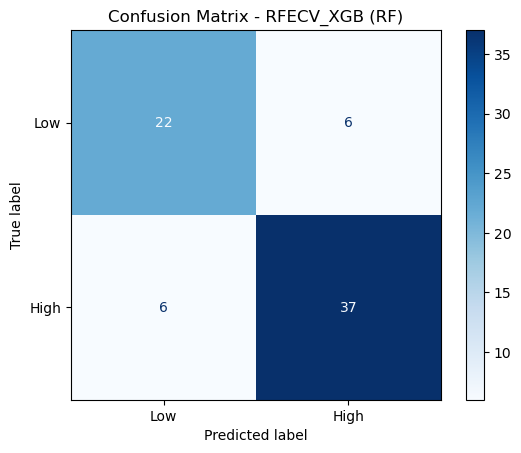

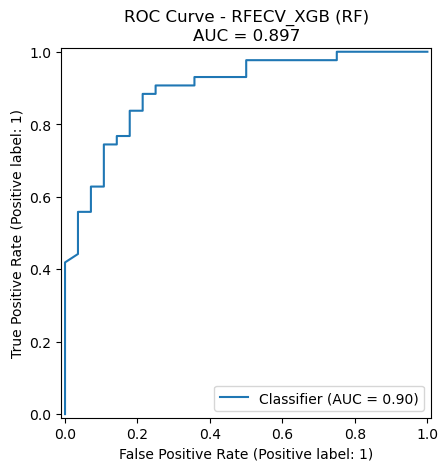


=== 📊 Classification Report ===
              precision    recall  f1-score   support

         Low     0.7857    0.7857    0.7857        28
        High     0.8605    0.8605    0.8605        43

    accuracy                         0.8310        71
   macro avg     0.8231    0.8231    0.8231        71
weighted avg     0.8310    0.8310    0.8310        71


=== ✅ Top1 모델 성능 요약 ===


,Test Set
Accuracy,0.830986
Balanced Accuracy,0.823090
F1,0.860465
Precision,0.860465
Recall,0.860465
ROC AUC,0.897425
MCC,0.646179


In [15]:
# ======================================
# ✅ 4️⃣ Top1 모델 시각화 (Confusion Matrix, ROC Curve, Summary)
# ======================================

import matplotlib.pyplot as plt
from sklearn.metrics import (
    confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay, classification_report
)

# -----------------------------
# 1️⃣ Top1 모델 식별
# -----------------------------
top1_row = combined_results_df.iloc[0]
best_source = top1_row["source"]
best_model_name = top1_row["model"]
stable_vars = list(stable_vars_dict[best_source])

print(f"\n✅ Top1 모델: {best_source} 기반 {best_model_name}")
print(f" - 안정적 변수 수: {len(stable_vars)}")
print(f" - composite_score = {top1_row['composite_score']:.4f}")

# -----------------------------
# 2️⃣ 실제 모델 객체 재구성
# -----------------------------
if best_model_name == "LogReg":
    best_model = Pipeline([
        ("scaler", StandardScaler()),
        ("clf", LogisticRegression(max_iter=1000, solver='liblinear', random_state=RANDOM_STATE))
    ])
elif best_model_name == "DT":
    best_model = DecisionTreeClassifier(random_state=RANDOM_STATE)
elif best_model_name == "RF":
    best_model = RandomForestClassifier(n_estimators=200, random_state=RANDOM_STATE, n_jobs=-1)
elif best_model_name == "XGB":
    best_model = XGBClassifier(n_estimators=200, random_state=RANDOM_STATE,
                               use_label_encoder=False, eval_metric='logloss', n_jobs=-1)
else:
    raise ValueError(f"Unknown model name: {best_model_name}")

# -----------------------------
# 3️⃣ 모델 학습 및 예측
# -----------------------------
best_model.fit(X_train[stable_vars], y_train)
y_pred = best_model.predict(X_test[stable_vars])

# 확률 스코어 (ROC용)
try:
    y_score = best_model.predict_proba(X_test[stable_vars])[:, 1]
except:
    try:
        y_score = best_model.decision_function(X_test[stable_vars])
    except:
        y_score = None

# -----------------------------
# 4️⃣ 혼동행렬
# -----------------------------
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Low", "High"])
disp.plot(cmap="Blues")
plt.title(f"Confusion Matrix - {best_source} ({best_model_name})")
plt.show()

# -----------------------------
# 5️⃣ ROC Curve
# -----------------------------
if y_score is not None:
    roc_display = RocCurveDisplay.from_predictions(y_test, y_score)
    auc_value = roc_display.roc_auc
    plt.title(f"ROC Curve - {best_source} ({best_model_name})\nAUC = {auc_value:.3f}")
    plt.show()
else:
    print("⚠️ 이 모델은 ROC Curve 계산용 확률출력을 지원하지 않습니다.")

# -----------------------------
# 6️⃣ Summary Report
# -----------------------------
print("\n=== 📊 Classification Report ===")
print(classification_report(y_test, y_pred, target_names=["Low", "High"], digits=4))

# -----------------------------
# 7️⃣ 주요 성능 요약 출력
# -----------------------------
summary_data = {
    "Accuracy": accuracy_score(y_test, y_pred),
    "Balanced Accuracy": balanced_accuracy_score(y_test, y_pred),
    "F1": f1_score(y_test, y_pred),
    "Precision": precision_score(y_test, y_pred, zero_division=0),
    "Recall": recall_score(y_test, y_pred),
    "ROC AUC": roc_auc_score(y_test, y_score) if y_score is not None else np.nan,
    "MCC": matthews_corrcoef(y_test, y_pred),
}

summary_df = pd.DataFrame(summary_data, index=["Test Set"]).T
print("\n=== ✅ Top1 모델 성능 요약 ===")
display(summary_df)

